# Varying Noise Experiment
In this notebook, we test our algorithm in setting where there is a lot of noise variance. We then compare our results to other methods on the same task.

In [1]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA

from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython 

from delphi.stats.linear_regression import TruncatedLinearRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata, Parameters

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [46]:
args = Parameters({
    "samples": 1500, # number of samples to generate for ground-truth
    "c": 0, # left truncation parameter
    "bs": 10,
    "lr": 1e-1,
    'var_lr': 1e-2,
    "trials": 20,
    "x_lower": -5,  # lower bound for generating input features
    "x_upper": 5,  # upper bound for generating input features
    "lower": -1, # lower bound for generating ground-truth
    "upper": 1, # lower bound for generating ground-truth
#     'out_dir': '<FILL IN OUT_DIR HERE>' 
#     'out_dir': '/Users/patroklos/Desktop/Adam_Var20_20Trials', 
#     'out_dir': '/Users/patroklos/Desktop/exp/more_reasonable', 
    'out_dir': '/Users/patroklos/Desktop/exp/unknown_var', 


#     'exp': '<FILL IN EXP HERE>', 
    'exp': '3_trials_var_lr_1e-2_1.5k', 
    'eps': 1e-2,
    'var': 10,  # maximum variance to use in procedure 
    'tol': 1e-1, 
    'val': 100,
    'bias': True, 
    'num_samples': 10, 
    'table_name': 'logs',
    'epochs': 2,
    'step_lr': 500,
    'num_trials': 3,
})

I will first begin, by showing how to use our algorithm in a 1 dimensional setting. I will sample input features from a Uniform distribution, I will also sample my ground-truth from a Uniform distribution, and I will add Gaussian noise with noise variance 10.

gt weight:  Parameter containing:
tensor([[-0.0417]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[0.4519]], requires_grad=True)
alpha:  tensor([0.6660])
gt ols coef:  [[-0.2387076]]
gt ols intercept:  [0.4447021]
trunc ols coef:  [[-0.20472741]]
trunc ols intercept:  [0.98529637]


Text(0, 0.5, 'y')

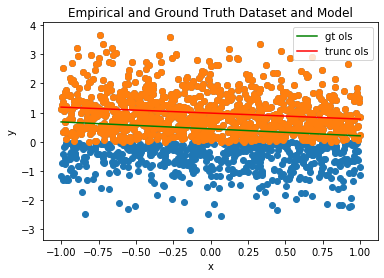

In [35]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(args.lower, args.upper)
m = Uniform(args.x_lower, args.x_upper)
phi = oracle.Left_Regression(Tensor([args.C]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)
    
# normalize input features
l_inf = LA.norm(X, dim=-1, ord=float('inf')).max()
beta = l_inf * (X.size(1) ** .5)

X /= beta

noise_var = Tensor([1.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(data, gt_ols.predict(data), color='green', label='gt ols')
plt.plot(data, trunc_ols.predict(data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

We now observe that the norm of the truncated x covariates is bounded by 1. 

Now, we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([0.4800])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

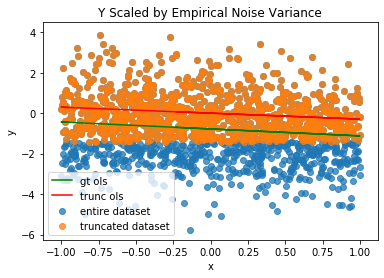

In [36]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

emp_stand_noised = (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(X, gt_emp_stand.predict(X), color='green', label='gt ols')
plt.plot(X, trunc_emp_stand_ols.predict(X), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.4800])
reg noise var:  tensor([0.9986])


Text(0, 0.5, 'y')

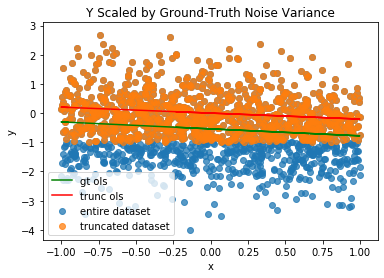

In [37]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(X, gt_stand.predict(X), color='green', label='gt ols')
plt.plot(X, trunc_stand_ols.predict(X), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

We will now run our procedure for truncated regression with known variance, assuming that the empirical noise variance is the actual noise variance. Since we applied feature transformations to our truncated dataset, we now need to reverse the trnasformations after the completion of our procedure.

In [38]:
known_emp_trunc_reg = TruncatedLinearRegression(phi=phi, 
                                                alpha=alpha, 
                                                noise_var=emp_noise_var, 
                                                val=args.val, 
                                                bs=args.bs,
                                                tol=args.lr, 
                                                step_lr=args.step_lr,
                                                epochs=args.epochs, 
                                                num_trials=args.trials)
known_emp_trunc_reg.fit(x_trunc, y_trunc)

Epoch 1 | Log Likelihood: 0.109
Epoch 2 | Log Likelihood: 0.121


Text(0, 0.5, 'y')

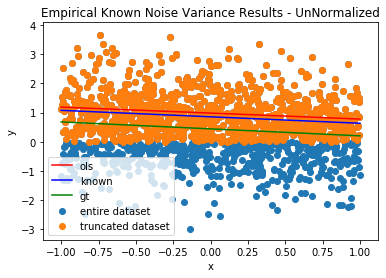

In [39]:
ax = plt.subplot(1, 1, 1)
plt.plot(data, trunc_ols.predict(data), color='red', label='ols')
plt.plot(data, known_emp_trunc_reg(Tensor(data)).detach().numpy(), label='known', color='blue')
plt.plot(data, gt_ols.predict(data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

We now run our procedure for truncated regression with known variance, assuming that we are given the ground-truth noise variance.

In [40]:
y_trunc_scale = y_trunc / ch.sqrt(noise_var)
phi_scale = oracle.Left_Regression(phi.left / ch.sqrt(noise_var))
known_trunc_reg = TruncatedLinearRegression(phi=phi_scale, 
                                            alpha=alpha, 
                                            noise_var=ch.ones(1, 1), 
                                            step_lr=args.step_lr,
                                            val=args.val,
                                            bs=args.bs, 
                                            epochs=args.epochs,
                                            tol=args.tol,
                                            num_samples=args.num_samples)
known_trunc_reg.fit(x_trunc, y_trunc_scale)
w = known_trunc_reg.coef_*ch.sqrt(noise_var)
w0 = known_trunc_reg.intercept_*ch.sqrt(noise_var)

Epoch 1 | Log Likelihood: 0.002
Epoch 2 | Log Likelihood: 0.03


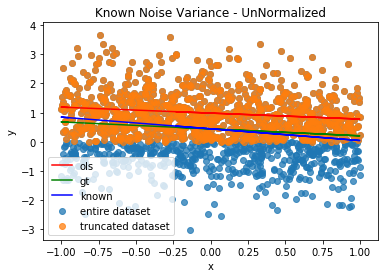

In [41]:
ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(X, trunc_ols.predict(X), color='r', label='ols')
plt.plot(X, gt_ols.predict(X), color='green', label='gt')
plt.plot(X, (X@w + w0).numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [42]:
y_trunc_emp_scale = y_trunc / ch.sqrt(emp_noise_var)
phi_emp_scale = oracle.Left_Regression(phi.left / ch.sqrt(emp_noise_var))
unknown_trunc_reg = TruncatedLinearRegression(phi=phi_emp_scale, 
                                              alpha=alpha, 
                                              lr=args.lr, 
                                              var_lr=args.var_lr, 
                                              bs=args.bs, 
                                              num_samples=args.num_samples,
                                              tol=args.tol, 
                                              val=args.val, 
                                              epochs=args.epochs)
unknown_trunc_reg.fit(x_trunc, y_trunc_emp_scale)
w = unknown_trunc_reg.coef_*ch.sqrt(emp_noise_var)
w0 = unknown_trunc_reg.intercept_*ch.sqrt(emp_noise_var)

Epoch 1 | Log Likelihood: 0.264
Epoch 2 | Log Likelihood: 0.235
Epoch 1 | Log Likelihood: 0.265
Epoch 2 | Log Likelihood: 0.275
Epoch 1 | Log Likelihood: 0.171
Epoch 2 | Log Likelihood: 0.18


/Users/patroklos/Desktop/delphi_/delphi/stats/linear_regression.py:370: UserWarning: Procedure did not converge, increase batch size of number of epochs.
  warnings.warn("Procedure did not converge, increase batch size of number of epochs.")


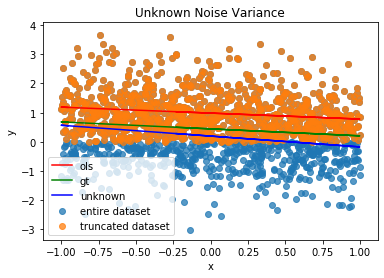

In [43]:
ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(X, trunc_ols.predict(X), label='ols', color='red')
plt.plot(X, gt_ols.predict(X), color='g', label='gt')
plt.plot(X, (X@w + w0).numpy(), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Generate Ground-Truth and Run Experiment

In [44]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 1, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left_Regression(0.0)
    
    
def gen_ground_truth(): 
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        y = gt(X)
        
    return X, y

In [47]:
# create store and add table
store = Store(args.out_dir + '/' + args.exp)
store.add_table(args.table_name, { 
    'ols_r2': float,
    'ols_param_mse': float,
    'ols_var_l1': float,
#     'known_emp_r2': float,
#     'known_emp_param_mse': float,
#     'known_emp_time': int,
    'known_r2': float,
    'known_param_mse': float,
    'known_time': int,
    'unknown_r2': float, 
    'unknown_param_mse': float,
    'unknown_var_l1': float,
    'unknown_time': int,
    'trunc_reg_r2': float,
    'trunc_reg_param_mse': float, 
    'trunc_reg_var_mse': float,
    'trunc_reg_time': int,
    'alpha': float, 
    'num_samples': int,
    'noise_var': float, 
})

for i in range(args.trials):
    # generate ground truth
    X, y = gen_ground_truth()
    
    # normalize input features
    l_inf = LA.norm(X, dim=-1, ord=float('inf')).max()
    beta = l_inf * (X.size(1) ** .5)

    X /= beta
        
    for noise_var in range(1, args.var + 1): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        # mean for dependent variable
        y_trunc_mu = y_trunc.mean(0)
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = (y_trunc - ols.predict(x_trunc)).var(0)
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[args.table_name].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        val = int(args.val * x_trunc.size(0))
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(ols_var)
        
        emp_stand_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(ols_var))
#         st = datetime.datetime.now()        
#         known_emp_trunc_reg = TruncatedLinearRegression(phi=emp_stand_phi, 
#                                                         alpha=alpha, 
#                                                         noise_var=emp_noise_var, 
#                                                         val=int(args.val*x_trunc.size(0)), 
#                                                         bs=args.bs, 
#                                                         n=args.n, 
#                                                         tol=args.tol, 
#                                                         steps=args.steps)
#         known_emp_trunc_reg.fit(x_trunc, emp_stand_y_trunc)    
#         total_time = int((datetime.datetime.now() - st).total_seconds())
#         w, w0 = (known_emp_trunc_reg.coef_ * ch.sqrt(emp_noise_var)), known_emp_trunc_reg.intercept_[..., None] * ch.sqrt(emp_noise_var) + y_trunc_mu
#         known_emp_params = ch.cat([w, w0], dim=1).flatten()

#         # known emp results
#         store[TABLE_NAME].update_row({
#             'known_emp_r2': r2_score(noised.flatten(), X@w.T + w0), 
#             'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
#             'known_emp_time': total_time, 
#         })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_phi = oracle.Left_Regression((phi.left - y_trunc_mu) / ch.sqrt(noise_var))

        st = datetime.datetime.now()        
        known_trunc_reg = TruncatedLinearRegression(phi=stand_phi, 
                                                    alpha=alpha, 
                                                    noise_var=ch.ones(1, 1), 
                                                    val=args.val, 
                                                    bs=args.bs, 
                                                    step_lr=args.step_lr,
                                                    epochs=args.epochs, 
                                                    num_trials=args.num_trials)
        known_trunc_reg.fit(x_trunc, stand_y_trunc)    
        total_time = int((datetime.datetime.now() - st).total_seconds())
        w, w0 = (known_trunc_reg.coef_ * ch.sqrt(noise_var)), known_trunc_reg.intercept_[..., None] * ch.sqrt(noise_var) + y_trunc_mu
        known_params = ch.cat([w, w0], dim=1).flatten()
        
        # known results
        store[args.table_name].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(gt_params, known_params),
            'known_time': total_time, 
        })

        st = datetime.datetime.now()        
        unknown_trunc_reg = TruncatedLinearRegression(phi=emp_stand_phi, 
                                                      alpha=alpha, 
                                                      lr=args.lr, 
                                                      var_lr=args.var_lr, 
                                                      step_lr=args.step_lr,
                                                      bs=args.bs, 
                                                      num_samples=args.num_samples,
                                                      tol=args.tol, 
                                                      val=args.val, 
                                                      epochs=args.epochs, 
                                                      num_trials=args.num_trials)
        unknown_trunc_reg.fit(x_trunc, emp_stand_y_trunc)
        total_time = int((datetime.datetime.now() - st).total_seconds())

        unknown_var = unknown_trunc_reg.variance * ols_var
        w, w0 = (unknown_trunc_reg.coef_ * ch.sqrt(ols_var)), unknown_trunc_reg.intercept_ * ch.sqrt(ols_var) + y_trunc_mu
        unknown_params = ch.cat([w, w0], dim=1).flatten()

        # known emp results
        store[args.table_name].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(gt_params, unknown_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
            
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        total_time = int((datetime.datetime.now() - st).total_seconds())
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[args.table_name].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': float(ch.abs(trunc_res[-1].pow(2)[None,...] - noise_var)),
            'trunc_reg_time': total_time, 
        })
        
        # add additional exp data to store
        store[args.table_name].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()

store.close()    

In [48]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 91.32it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,trunc_reg_r2,trunc_reg_param_mse,trunc_reg_var_mse,trunc_reg_time,alpha,num_samples,noise_var,exp_id
0,0.836110,0.467206,0.113836,0.886390,0.044077,0,0.851869,0.205231,0.805269,0,0.889920,0.030062,0.017421,0,0.512000,768,1.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
1,0.608409,1.795289,0.474591,0.760878,0.475894,0,0.795740,0.051246,1.133052,0,0.800986,0.035440,0.095216,0,0.514667,772,2.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
2,0.441923,2.875022,0.854565,0.663262,0.820087,0,0.704957,0.390202,0.409640,0,0.738471,0.005893,0.027372,0,0.506667,760,3.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
3,0.332617,3.543139,1.202816,0.566645,1.105417,0,0.616018,0.583255,0.702056,0,0.668220,0.000353,0.181400,0,0.509333,764,4.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
4,0.198204,4.694724,2.005870,0.553614,0.812456,0,0.618734,0.022381,0.997841,0,0.619776,0.022549,0.305457,0,0.518000,777,5.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
5,0.170211,4.551796,2.529316,0.562867,0.259033,0,0.457382,0.830319,1.450604,0,0.545055,0.377028,0.047481,0,0.516667,775,6.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
6,0.131379,5.287916,2.828104,0.470526,1.366146,0,0.528974,0.435648,1.882097,0,0.564693,0.057332,0.015936,0,0.491333,737,7.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
7,0.047653,5.544562,3.508570,0.469804,0.451268,0,0.451031,0.458385,1.621391,0,0.472716,0.487508,0.549061,0,0.492000,738,8.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
8,-0.014690,6.765501,3.995093,0.419095,0.860859,0,0.373533,1.386939,2.728182,0,0.485726,0.006498,0.284324,0,0.510000,765,9.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251
9,-0.108599,7.317676,4.755408,0.377368,0.987540,0,0.425414,0.055257,1.150946,0,0.427325,0.019508,0.583799,0,0.514667,772,10.0,b3060d73-b3de-43f2-ab5f-fc7e8bc49251


In [49]:
logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
logs['trunc_reg_epsilon'] = logs['trunc_reg_param_mse'] + logs['trunc_reg_var_mse']
logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

In [50]:
logs['unknown_param_mse'] = logs['unknown_param_mse'] **(1/2)
logs['known_param_mse'] = logs['known_param_mse'] **(1/2)
logs['ols_param_mse'] = logs['ols_param_mse'] **(1/2)
# known_emp_logs['known_emp_param_mse'] = known_emp_logs['known_emp_param_mse'] **(1/2)
logs['trunc_reg_param_mse'] = logs['trunc_reg_param_mse'] **(1/2)

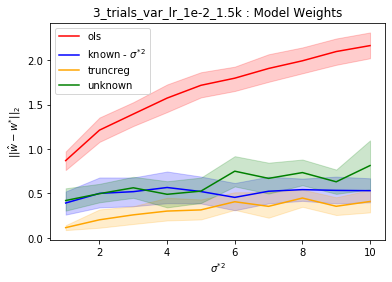

Text(0.5, 1.0, '3_trials_var_lr_1e-2_1.5k : Variance')

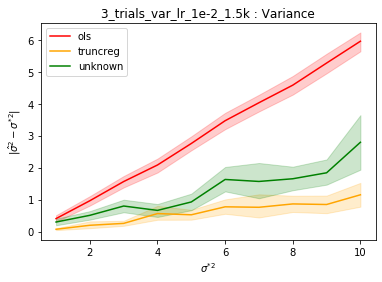

In [51]:
sns.lineplot(data=logs, x='noise_var', y='ols_param_mse', label='ols', color='r')
# sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', color='purple', label='known - $\sigma_{0}^{2}$')
sns.lineplot(data=logs, x='noise_var', y='known_param_mse', label='known - $\sigma^{*2}$', color='blue')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_param_mse', label='unknown', color='green')

ax.set(xlabel='$\sigma^{*2}$', ylabel='$||\hat w - w^{*}||_{2}$')
ax.set_title(args.exp + " : Model Weights")
plt.show()

sns.lineplot(data=logs, x='noise_var', y='ols_var_l1', label='ols', color='red')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_var_l1', label='unknown', color='green')
ax.set(xlabel='$\sigma^{*2}$', ylabel='$|\hat \sigma^{2} - \sigma^{*2}|$')
ax.set_title(args.exp + " : Variance")

In [54]:
logs[logs.noise_var == 4].unknown_param_mse

3      0.249747
13     0.619681
23     0.613911
33     0.178698
43     1.384446
53     0.680082
63     1.243512
73     1.623943
83     0.370584
93     0.290005
103    1.311668
113    1.320348
123    1.353006
133    0.474031
143    0.682178
153    0.110649
163    0.312205
173    1.167492
183    1.352394
193    0.578123
Name: unknown_param_mse, dtype: float64

In [142]:
unknown_params

tensor([2.2949, 1.3439])

In [143]:
gt_unknown_params

tensor([2.9996, 0.0822])

In [144]:
known_params

tensor([2.1468, 0.4931])

In [145]:
gt_known_params

tensor([2.9996, 0.0822])

tensor(False)

In [74]:
import torch.linalg as LA
l_inf = LA.norm(X, dim=-1, ord=float('inf')).max()
beta = l_inf * X.size(1) ** (.5)

In [75]:
x_norm = X / beta

In [76]:
gt_norm = LinearRegression()
gt_norm.fit(x_norm, y)

LinearRegression()

In [78]:
norm_w = np.concatenate([gt_norm.coef_, gt_norm.intercept_.reshape(-1, 1)], axis=1)

In [80]:
w_ = np.concatenate([gt_ols.coef_, gt_ols.intercept_.reshape(-1, 1)], axis=1)

In [81]:
norm_w / w_

array([[15.91523  , 15.874461 , 21.831177 , 15.561473 , 15.849096 ,
        15.670087 , 15.684167 , 15.925425 , 15.788613 , 15.7659235,
         1.0026407]], dtype=float32)

In [83]:
beta

tensor(15.8109)

In [99]:
unknown_params[-1], gt_unknown_params[:,-1]

(tensor(2.8282), tensor([0.0923]))

In [100]:
gt_unknown_params[:,-1]

tensor([0.0923])

In [101]:
y_trunc_mu

tensor([5.0255])